In [1]:
import matplotlib.pyplot as plt
import glob
import os
import json
import numpy as np
import pandas as pd
from scipy import stats

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.handlelength"] = 2

In [2]:
bad = ['D173', 'D50', 'D56', 'D86', 'D48']
bad = []

def load_json(base_dir='./json_data', target_file=None):
    datas = []
    if not target_file:
        filepath = '/'.join([base_dir, '*.json'])
        target_file = max(glob.glob(filepath), key = os.path.getctime)
    print(target_file)
    with open(target_file, 'r') as file:
        for line in file.readlines():
            data = json.loads(line)
            if data['name'] in bad:
                continue
            datas.append(data)

    return datas

In [3]:
# datas = load_json(target_file='./json_data/results_1657047590.json')
# datas = load_json(target_file='./json_data/results_1657070739.json')

datas = load_json(target_file='./json_data/results_1657177286.json')
# datas = load_json(target_file='./json_data/results_1657279563.json')
datas = load_json(target_file='./json_data/results_1657502170.json')

./json_data/results_1657177286.json
./json_data/results_1657502170.json


In [4]:
def plot_prediction(datas, model, dataset_name='', n_dataset=1, only_test=True):
        n_dataset_list = set()
        base = True
        df = pd.DataFrame()

        for data in datas:
            if model not in data['untransformed']:
                return

            if dataset_name and data['name'] != dataset_name:
                continue
            if len(n_dataset_list) < n_dataset:
                n_dataset_list.add(data['name'])
            if data['name'] not in n_dataset_list:
                continue

            train = np.array(data['train_y']).ravel()
            test = np.array(data['test_y']).ravel()

            if only_test:
                test_time_idx = range(len(test))[:100]
            else:
                train_time_idx = range(len(train)+len(test))[:len(train)]
                test_time_idx = range(len(train)+len(test))[len(train):]

            if base:
                if not only_test:
                    plt.plot(train_time_idx, train, linewidth=8, alpha=0.5)
                plt.plot(test_time_idx, test[:100], label='test data', linewidth=8, alpha=0.5)
                plt.title(f'Series: {data["name"]}, Model: {model}')
                plt.legend()
                base = False

            pred = data['untransformed'][model]['prediction'][:100]
            label = f"untransformed series, Lag: {data['untransformed'][model]['lags']}, SMAPE: {data['untransformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['untransformed'][model]['root_mean_squared_error']}"
            plt.plot(test_time_idx, pred, label=label, linewidth=5, alpha=0.5)
            
            pred = data['transformed'][model]['prediction'][:100]
            label = f"threshold: {data['transformed'][model]['threshold']}, Lag: {data['transformed'][model]['lags']}, SMAPE: {data['transformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['transformed'][model]['root_mean_squared_error']}"
            plt.plot(test_time_idx, pred, label=label, linewidth=2.5, alpha=0.8)
            
            # plt.plot(range(len(train)+len(test))[len(train):], pred, label=label, linewidth=1, alpha=0.8)
            plt.legend()

            # score = {data['threshold']: [data[model]['root_mean_squared_error'], data[model]['r2'], data[model]['symmetric_mean_absolute_percentage_error']]}
            # this = pd.DataFrame(score, index=['root_mean_squared_error', 'r2', 'symmetric_mean_absolute_percentage_error'])
            # df = pd.concat([df, this], axis=1)

        plt.tight_layout()
        plt.show()
        # df.columns = pd.MultiIndex.from_product([[f'{model}, Threshold'], df.columns])
        # return df

In [5]:
def smape_result():
    smape_df = pd.DataFrame()
    info = dict()
    for data in datas:
        dataset_name = data['name']
        for key in ['untransformed', 'transformed']:
            for model_name, model_val in data[key].items():
                if model_name not in info:
                    info[model_name] = dict()
                info[model_name][key] = model_val['symmetric_mean_absolute_percentage_error']
        reform = {(outerKey, innerKey): values for outerKey, innerDict in info.items() for innerKey, values in dict(innerDict).items()}
        # print(reform)
        df = pd.DataFrame(reform, index=[dataset_name])
        # df.columns = pd.MultiIndex.from_product([[dataset_name], df.columns])
        # return df
        # df = pd.DataFrame.from_dict(info, orient='columns')
        # df.columns = pd.MultiIndex.from_product([[dataset_name], df.columns])
        # return df
        smape_df = pd.concat([smape_df, df], axis=0)
    # smape_df.drop(index=['D173', 'D50', 'D56', 'D86', 'D48'], inplace=True)
    smape_df.loc[('Total',)] = smape_df.sum()
    return smape_df.sort_index()

smape_df = smape_result()
smape_df
# for i, col in enumerate(smape_df.columns):
#     q_h = smape_df.iloc[:, i].quantile(0.99)
#     q_l = smape_df.iloc[:, i].quantile(0.01)
#     # print(q_l, col, q_h)


# smape_df

ElasticNet             RandomForestRegressor              \
      untransformed transformed         untransformed transformed   
D10           0.044       0.044                 0.045       0.045   
Total         0.044       0.044                 0.045       0.045   

       MLPRegressor                       GRU                      LSTM  \
      untransformed transformed untransformed transformed untransformed   
D10           0.044       0.045         0.046       0.082         0.046   
Total         0.044       0.045         0.046       0.082         0.046   

                        AutoETS              
      transformed untransformed transformed  
D10         0.082         0.044       0.045  
Total       0.082         0.044       0.045

['ElasticNet(u)', 'ElasticNet(t)', 'RandomForestRegressor(u)', 'RandomForestRegressor(t)', 'MLPRegressor(u)', 'MLPRegressor(t)', 'GRU(u)', 'GRU(t)', 'LSTM(u)', 'LSTM(t)', 'AutoETS(u)', 'AutoETS(t)']


<AxesSubplot:>

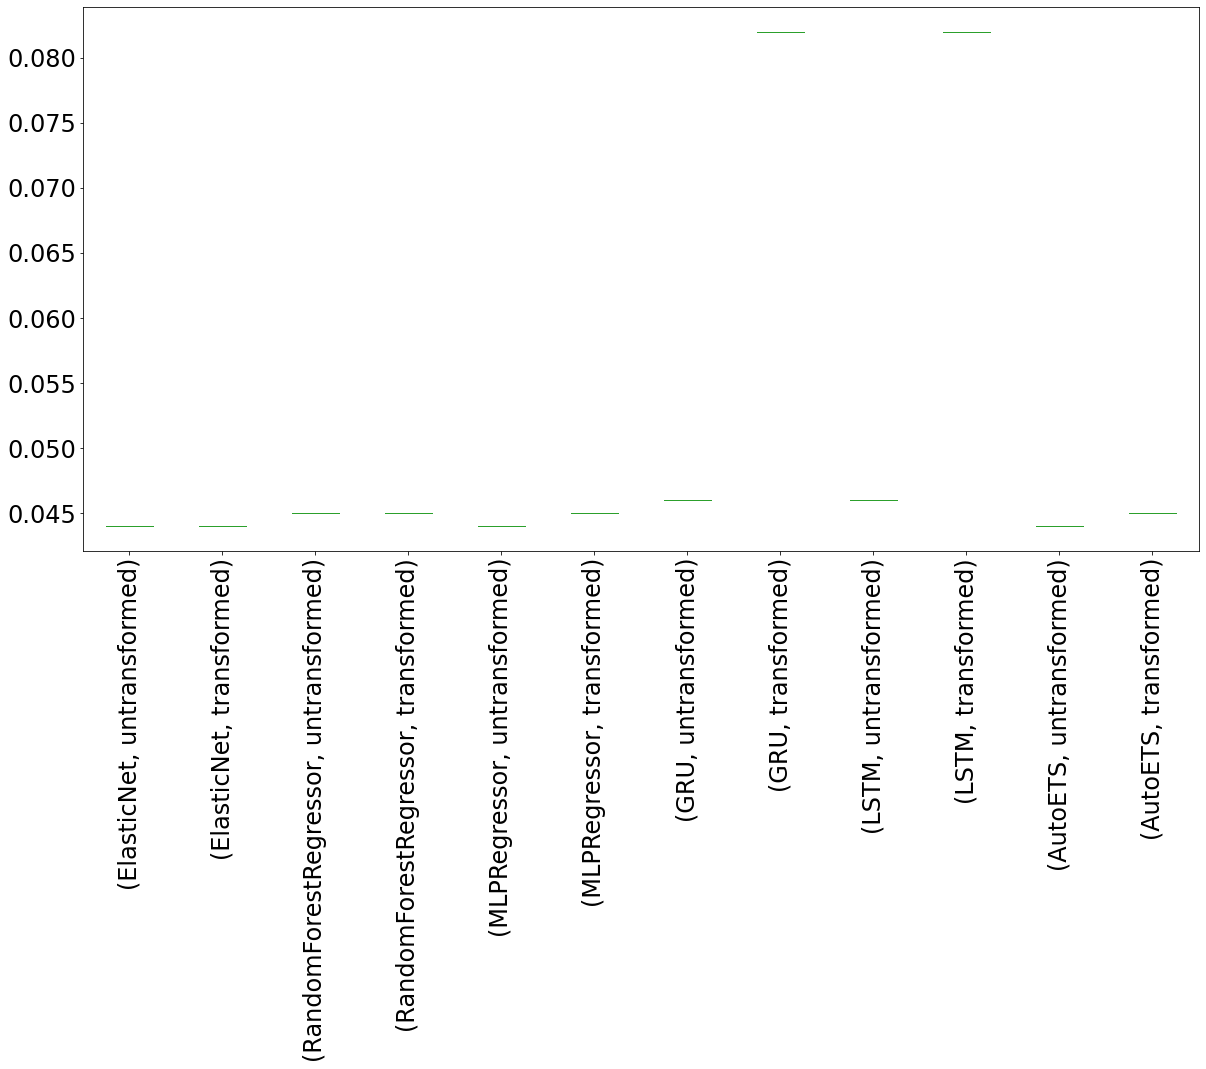

In [6]:
print([f'{m}({t[0]})' for m, t in smape_df.columns])

smape_df.boxplot(grid=False, showfliers=False, rot=90)

In [7]:
def ranking():
    ranking = dict()
    frac_best  =  dict()
    for data in datas:
        for key in ['untransformed', 'transformed']:
            tmp_rank = []
            for model_name, model_val in data[key].items():
                if model_name not in ranking:
                    ranking[model_name] = dict()
                    frac_best[model_name] = dict()
                if key not in frac_best[model_name]:
                    ranking[model_name][key] = 0
                    frac_best[model_name][key] = 0
                tmp_rank.append((model_name, model_val['symmetric_mean_absolute_percentage_error']))
            rank = sorted(tmp_rank, key=lambda x: x[1])


            for rank_idx in range(len(rank)):
                model_name, _ = rank[rank_idx]
                ranking[model_name][key] += (rank_idx + 1)
                if rank_idx == 0:
                    frac_best[model_name][key] += 1

    df = pd.DataFrame.from_dict(ranking) / len(datas)
    frac_df = pd.DataFrame.from_dict(frac_best) / len(datas) * 100
    df.loc['mean'] = df.mean()
    frac_df.loc['mean'] = frac_df.mean()
    df.index = pd.MultiIndex.from_product([['RANK'], df.index])
    frac_df.index = pd.MultiIndex.from_product([['FRAC-BEST(%)'], frac_df.index])
    return pd.concat([df, frac_df], axis=0)

rf_df = ranking()

In [8]:
new_smape = dict()
smape_dict = smape_df.loc['Total'].to_dict()
for (model_name, key), smape in smape_dict.items():
    if model_name not in new_smape:
        new_smape[model_name] = dict()
    if key not in new_smape[model_name]:
        new_smape[model_name][key] = smape

tot_smape_df = pd.DataFrame(new_smape)
tot_smape_df.loc['total'] = tot_smape_df.sum()
tot_smape_df.index = pd.MultiIndex.from_product([['sMAPE'], tot_smape_df.index])

pd.concat([tot_smape_df, rf_df], axis=0)

ElasticNet  RandomForestRegressor  MLPRegressor  \
sMAPE        untransformed       0.044                  0.045         0.044   
             transformed         0.044                  0.045         0.045   
             total               0.088                  0.090         0.089   
RANK         untransformed       1.000                  4.000         2.000   
             transformed         1.000                  2.000         3.000   
             mean                1.000                  3.000         2.500   
FRAC-BEST(%) untransformed     100.000                  0.000         0.000   
             transformed       100.000                  0.000         0.000   
             mean              100.000                  0.000         0.000   

                              GRU   LSTM  AutoETS  
sMAPE        untransformed  0.046  0.046    0.044  
             transformed    0.082  0.082    0.045  
             total          0.128  0.128    0.089  
RANK         untransformed  5.000  6.000    3.000  
             transformed    5.000  6.000    4.000  
             mean           5.000  6.000    3.500  
FRAC-BEST(%) untransformed  0.000  0.000    0.000  
             transformed    0.000  0.000    0.000  
             mean           0.000  0.000    0.000

In [9]:
def cal_threshold():
    thresholds = dict()
    better_thresholds = dict()
    for data in datas:
        key = 'transformed'
        for model_name, model_val in data[key].items():
            if model_name not in thresholds:
                thresholds[model_name] = dict()
                better_thresholds[model_name] = dict()
            if model_val['threshold'] not in thresholds[model_name]:
                thresholds[model_name][model_val['threshold']] = 0
                better_thresholds[model_name][model_val['threshold']] = 0

            thresholds[model_name][model_val['threshold']] += 1
            if model_val['symmetric_mean_absolute_percentage_error'] < data['untransformed'][model_name]['symmetric_mean_absolute_percentage_error']:
                better_thresholds[model_name][model_val['threshold']] += 1
        
    df = pd.DataFrame.from_dict(thresholds).sort_index().fillna(0).astype(int)
    df['Total'] = df.sum(axis=1)
    df.loc['Total'] = df.sum(axis=0)
    df.index = pd.MultiIndex.from_product([['Optimal Threshold'], df.index])

    better_df = pd.DataFrame.from_dict(better_thresholds).sort_index().fillna(0).astype('object')
    better_df.loc['Total(%)'] = better_df.sum(axis=0) / len(datas) * 100
    better_df['Total(%)'] = round(better_df.sum(axis=1) / df['Total'].values * 100)
    better_df.index = pd.MultiIndex.from_product([['Better than raw data'], better_df.index])
    return df.T, better_df.astype(int).T

df, better_df = cal_threshold()
df

Optimal Threshold           
                                  0.005 0.01 Total
ElasticNet                            0    1     1
RandomForestRegressor                 1    0     1
MLPRegressor                          1    0     1
GRU                                   0    1     1
LSTM                                  0    1     1
AutoETS                               1    0     1
Total                                 3    3     6

In [10]:
better_df.iloc[-1,-1] = np.nan
better_df

Better than raw data              
                                     0.005 0.01 Total(%)
ElasticNet                               0    0      0.0
RandomForestRegressor                    0    0      0.0
MLPRegressor                             0    0      0.0
GRU                                      0    0      0.0
LSTM                                     0    0      0.0
AutoETS                                  0    0      0.0
Total(%)                                 0    0      NaN

In [11]:
def cal_lag(index='lags'):
    lags = dict()
    for data in datas:
        for key in ['untransformed', 'transformed']:
            for model_name, model_val in data[key].items():
                if model_name in ['AutoETS']:
                    continue
                if model_name not in lags:
                    lags[model_name] = dict()
                if key not in lags[model_name]:
                    lags[model_name][key] = dict()
                if model_val[index] not in lags[model_name][key]:
                    lags[model_name][key][model_val[index]] = 0

                lags[model_name][key][model_val[index]] += 1
    reform = {(outerKey, innerKey): values for outerKey, innerDict in lags.items() for innerKey, values in dict(innerDict).items()}
    df = pd.DataFrame(reform).sort_index().fillna(0).astype(int)
    # df.drop(index='AutoETS', inplace=True)
    df['Total'] = df.sum(axis=1)
    df.index = pd.MultiIndex.from_product([['Lag'], df.index])
    return df.T

df = cal_lag(index='lags')


df

Lag   
                                      2  4
ElasticNet            untransformed   0  1
                      transformed     1  0
RandomForestRegressor untransformed   1  0
                      transformed     0  1
MLPRegressor          untransformed   0  1
                      transformed     1  0
GRU                   untransformed   1  0
                      transformed     0  1
LSTM                  untransformed   0  1
                      transformed     1  0
Total                                 5  5

In [12]:
df = pd.concat([list(df.groupby(level=1))[1][1].sum(), list(df.groupby(level=1))[2][1].sum()], axis=1).T.astype(int)
df.index = ['transformed(sum)', 'untransformed(sum)']
df

Lag   
                     2  4
transformed(sum)     3  2
untransformed(sum)   2  3

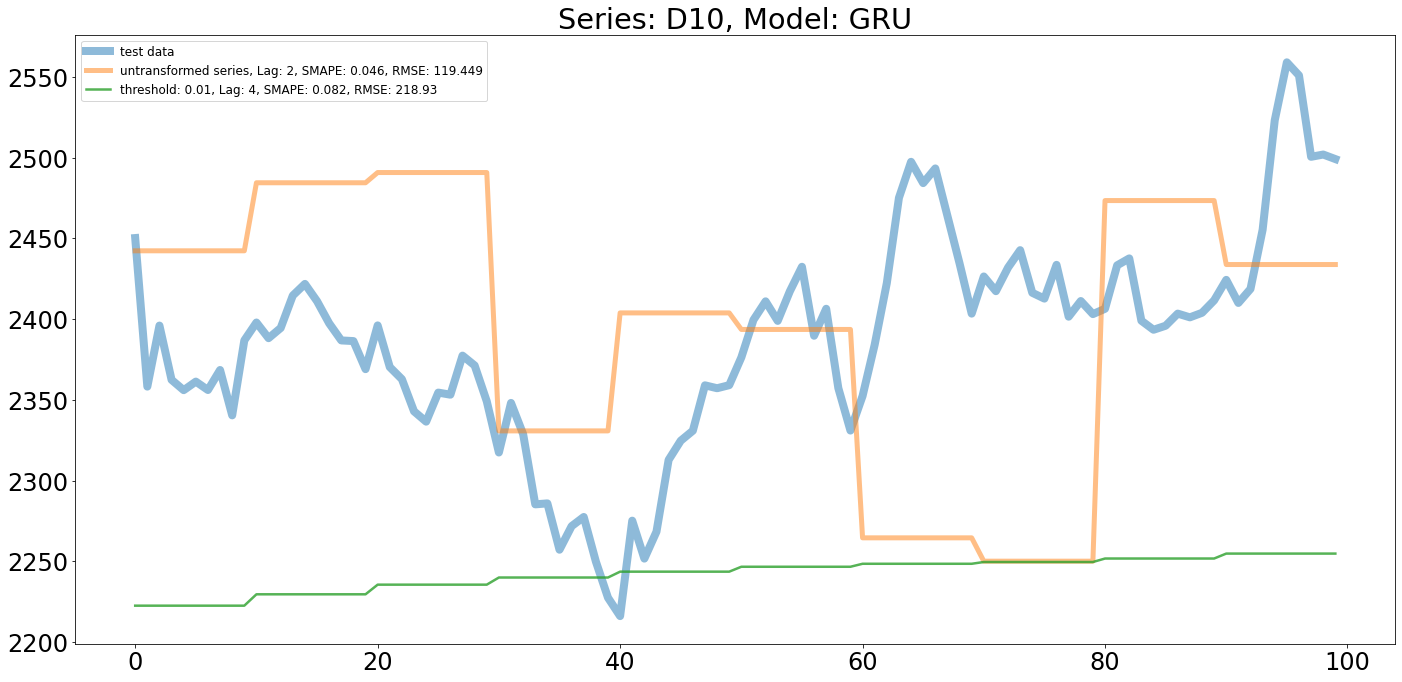

In [13]:
plot_prediction(datas, model='GRU', only_test=True)

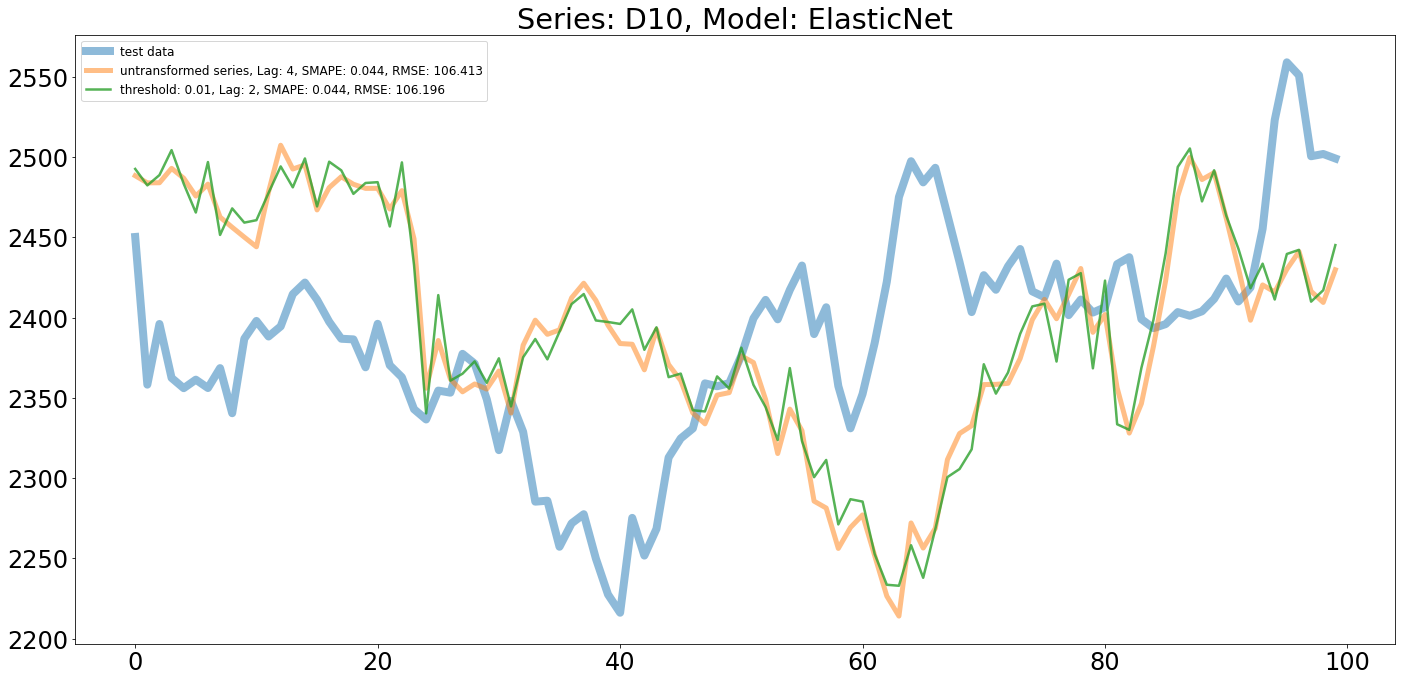

In [14]:
plot_prediction(datas, model='ElasticNet', only_test=True)

In [15]:
# plot_prediction(datas, model='KNeighborsRegressor')

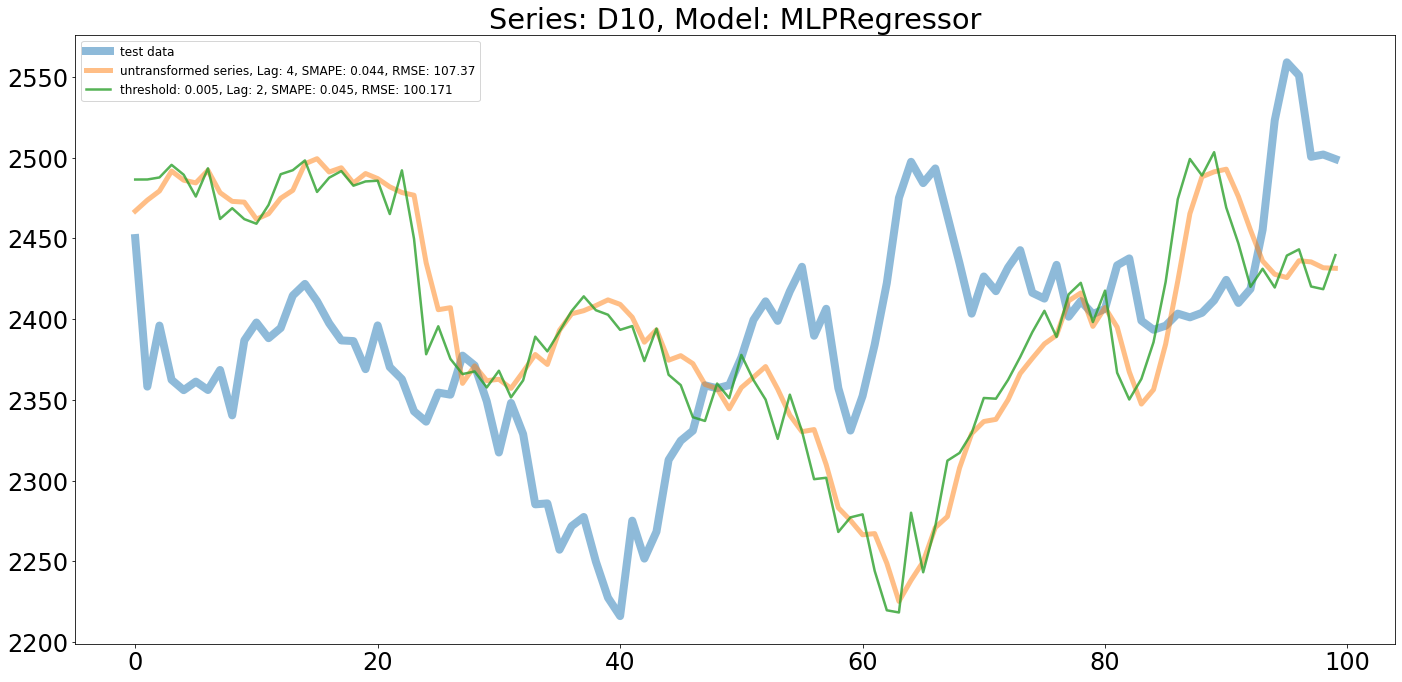

In [16]:
plot_prediction(datas, model='MLPRegressor')

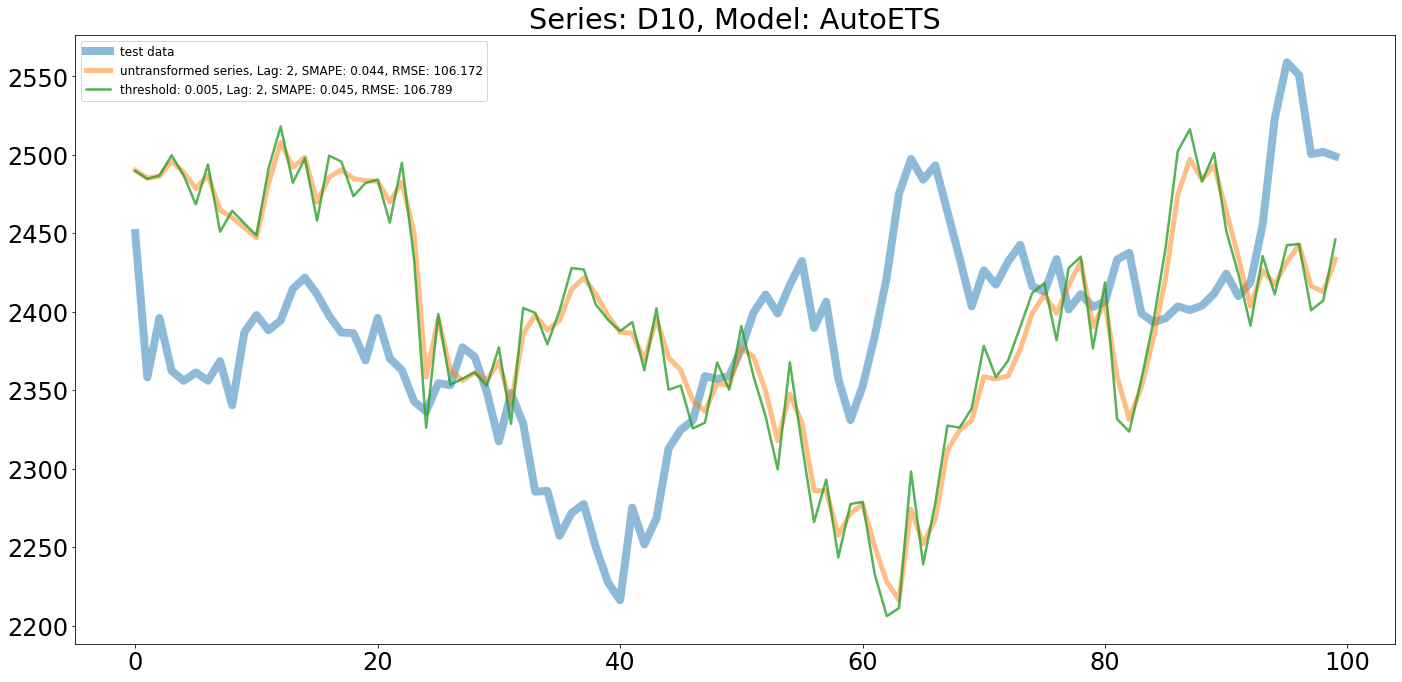

In [17]:
plot_prediction(datas, model='AutoETS', only_test=True)

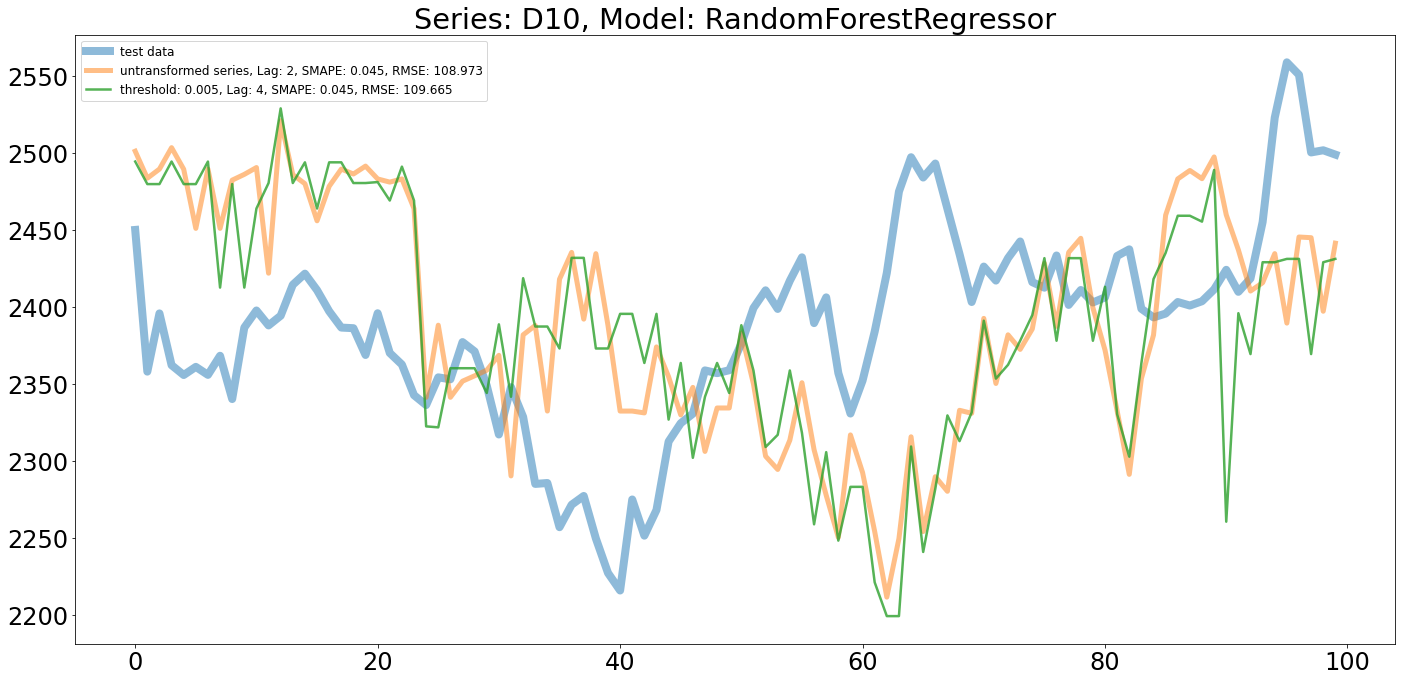

In [18]:
plot_prediction(datas, model='RandomForestRegressor')

In [19]:
plot_prediction(datas, model='LinearSVR')

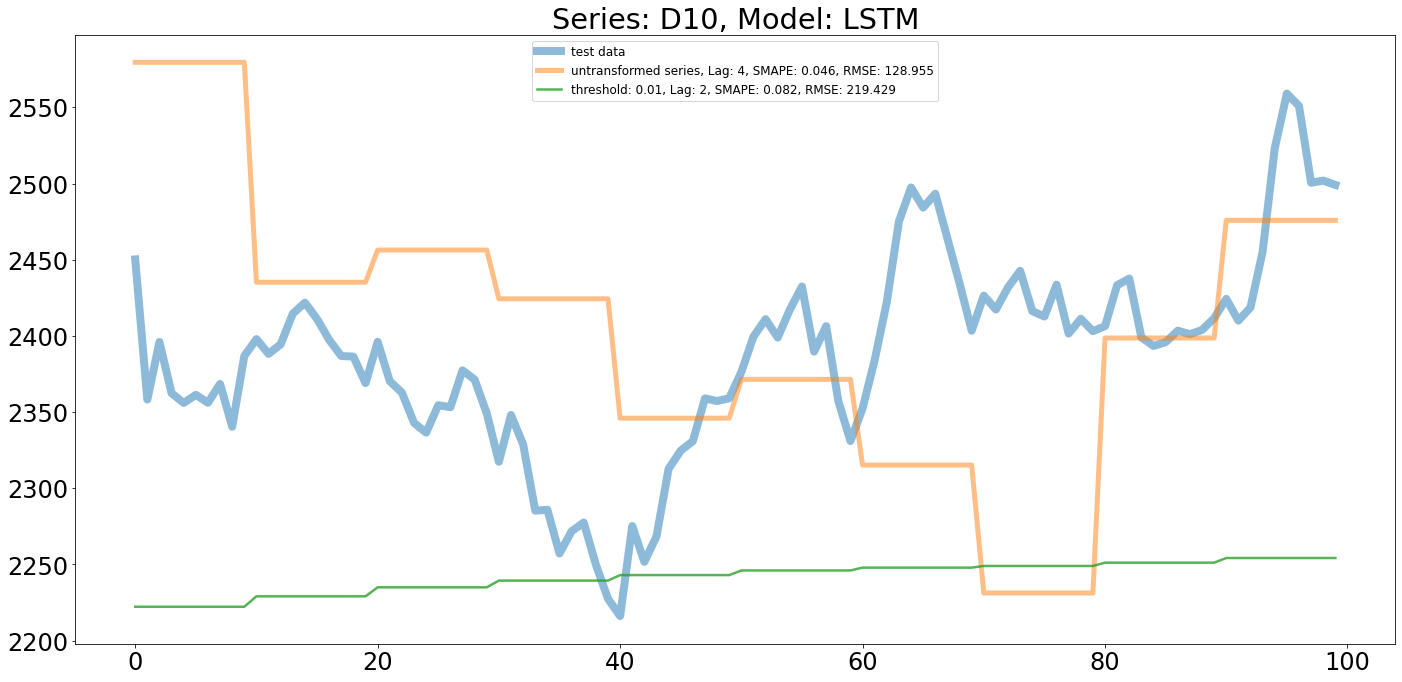

In [20]:
plot_prediction(datas, model='LSTM')